In [20]:
%load_ext autoreload
%autoreload 2
from hyperopt.fnn import HyperOptFnn
from hyperopt.sklearn_gridsearch import HyperOptScikitFda
from shapley.shapley_fda import ShapleyFda
from skfda.misc.operators import LinearDifferentialOperator
from skfda.misc.regularization import L2Regularization
from skfda.ml.regression import KNeighborsRegressor, LinearRegression
from skfda.representation.basis import FDataBasis, BSplineBasis
from skfda.representation.grid import FDataGrid
from utils.predict_np import predict_from_np
from utils.simulator import FdaSimulator
import matplotlib.pyplot as plt
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
n_basis_representation = 10
basis_bsplines = BSplineBasis(
    n_basis=n_basis_representation,
    domain_range=(0 ,1)
)

In [22]:
fda_simulator = FdaSimulator()

In [23]:
# Prepare some global parameters used to generate data
cnt = 30
alpha_p =  1 * cnt
beta_p = 3 * cnt
positions = [0.15, 0.35, 0.55, 0.85]
n_basis_simulated_data = 11

X, phi_X, epsilon, beta_data, col_indexes_bct, target = fda_simulator.simulate(
    type_covariate="fourier_expansion",
    type_transformation="linear_bimodal",
    sample_size=200,
    eta=0.05,
    datasets_type = ["train", "validation", "test"],
    # Series representation
    n_basis_simulated_data=n_basis_simulated_data,
    sd_x=0.01,
    # Beta parameters
    alpha_param=alpha_p,
    beta_param=beta_p,
    # Brownian parameters
    intercept_brownian=0,
    slope_brownian=1,
    positions=positions
)

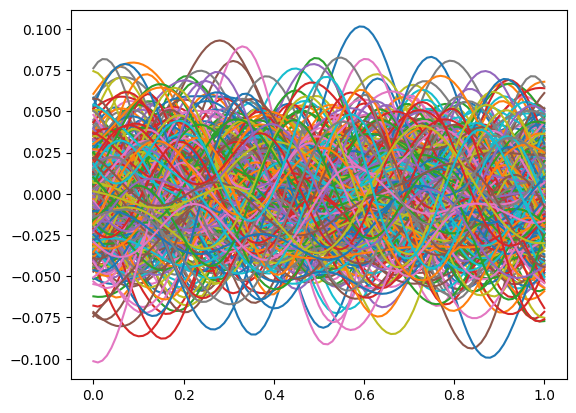

In [24]:
X_train, X_validation, X_test = X
X_full = np.row_stack((X_train, X_validation))

target_train, target_validation, target_test = target
target_full = np.row_stack((target_train, target_validation))

beta_train, beta_validation, beta_test = beta_data

X_train_grid = fda_simulator.to_fdata_grid(X_train)
X_validation_grid = fda_simulator.to_fdata_grid(X_validation)
X_test_grid = fda_simulator.to_fdata_grid(X_test)
X_full_grid = fda_simulator.to_fdata_grid(X_full)

X_train_bspline = X_train_grid.to_basis(basis_bsplines)
X_validation_bspline = X_validation_grid.to_basis(basis_bsplines)
X_test_bspline = X_test_grid.to_basis(basis_bsplines)
X_full_bspline = X_full_grid.to_basis(basis_bsplines)
zzz = X_full_grid.plot()

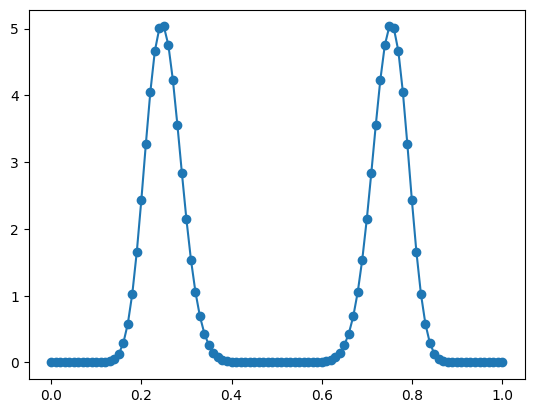

In [25]:
if not beta_train is None:
    beta_data_grid = fda_simulator.to_fdata_grid(beta_train)
    plt.plot(
        fda_simulator.abscissa_points,
        np.reshape(beta_train, newshape=(1, -1))[0], '-o'
    )

# Linear model

In [26]:
def L2reg(lambda_value):
    operator = L2Regularization(
        linear_operator=LinearDifferentialOperator(2),
        regularization_parameter=lambda_value
    )
    return operator

In [27]:
hyperopt_lm = HyperOptScikitFda(
    LinearRegression,
    abscissa_points=fda_simulator.abscissa_points,
    domain_range=fda_simulator.domain_range,
)
reg_list = [L2reg(x) for x in np.arange(0.2, 1.5, 0.2)]
reg_list.append(None)
params_lm = {
    "regularization": reg_list
}
hist_lm = hyperopt_lm.search(
    params=params_lm,
    X_train=X_train_bspline,
    y_train=target_train[:, 0],
    X_val=X_validation_bspline,
    y_val=target_validation[:, 0]
)

In [28]:
best_params_lm = hist_lm.best_params_
print(best_params_lm)
best_model_lm = hyperopt_lm.cls_estimator(**best_params_lm)

{'regularization': None}


In [29]:
_ = best_model_lm.fit(X_full_bspline, target_full[:, 0])

In [30]:
num_intervals = 20
num_permutations = 1000

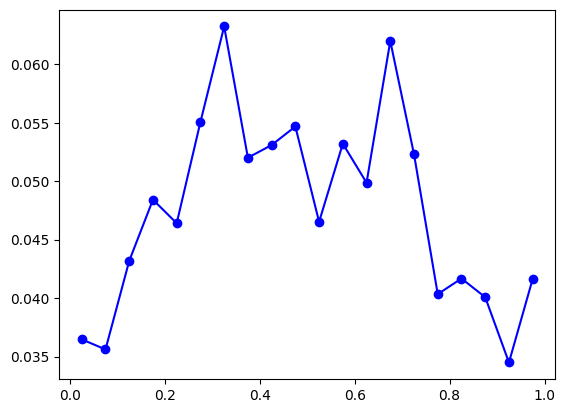

In [31]:
# Transform predict function to use a numpy array as input
pred_lm = predict_from_np(
    grid_points=fda_simulator.abscissa_points,
    domain_range=fda_simulator.domain_range,
    basis=X_full_bspline.basis,
    predict_fn=best_model_lm.predict
)

shapley_fda_lm = ShapleyFda(
    predict_fn=pred_lm,
    X=X_test,
    abscissa_points=fda_simulator.abscissa_points,
    target=target_test[:, 0],
    domain_range=fda_simulator.domain_range,
    verbose=False,
)

values_shapley_lm = shapley_fda_lm.compute_shapley_value(
    num_intervals=num_intervals,
    num_permutations=num_permutations,
    seed=10,
)
shapley_fda_lm.plot()

In [ ]:
#linear_reg_2 = LinearRegression()
#_ = linear_reg_2.fit(X_full_bspline, target_full[:, 0])
#pred_lm_2 = predict_from_np(
#    grid_points=fda_simulator.abscissa_points,
#    domain_range=fda_simulator.domain_range,
#    basis=X_full_bspline.basis,
#    predict_fn=linear_reg_2.predict
#)
#shapley_fda_lm_2 = ShapleyFda(
#    predict_fn=pred_lm_2,
#    X=X_test,
#    abscissa_points=fda_simulator.abscissa_points,
#    target=target_test[:, 0],
#    domain_range=fda_simulator.domain_range,
#    verbose=False,
#)
#values_shapley_lm_2 = shapley_fda_lm_2.compute_shapley_value(
#    num_intervals=num_intervals,
#    num_permutations=num_permutations,
#    seed=10,
#)
#shapley_fda_lm_2.plot()

# Knn

In [13]:
hyperopt_knn = HyperOptScikitFda(
    KNeighborsRegressor,
    abscissa_points=fda_simulator.abscissa_points,
    domain_range=fda_simulator.domain_range,
)

hist_knn = hyperopt_knn.search(
    params={"n_neighbors": range(3, 12, 2)},
    X_train=X_train,
    y_train=target_train,
    X_val=X_validation,
    y_val=target_validation
)

best_params_knn = hist_knn.best_params_
print(best_params_knn)
best_model_knn = hyperopt_knn.cls_estimator(**best_params_knn)
_ = best_model_knn.fit(X_full, target_full)

{'n_neighbors': 5}


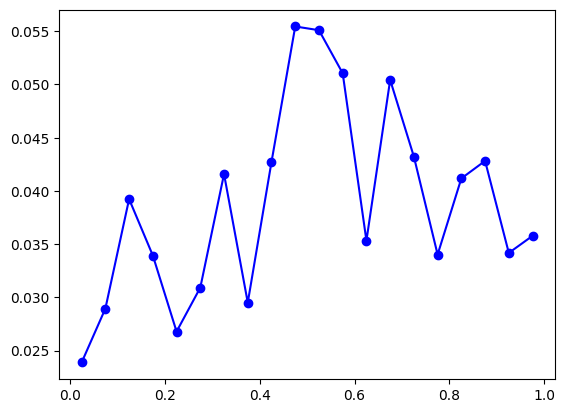

In [14]:
shapley_fda_knn = ShapleyFda(
    predict_fn=best_model_knn.predict,
    X=X_test,
    abscissa_points=fda_simulator.abscissa_points,
    target=target_test,
    domain_range=fda_simulator.domain_range,
    verbose=False,
)

values_shapley_knn = shapley_fda_knn.compute_shapley_value(
    num_intervals=num_intervals,
    num_permutations=num_permutations,
)
shapley_fda_knn.plot()

# Neural networks

In [15]:
def predict_no_verbose(predict_fn):
    def inner(*args, **kwargs):
        return predict_fn(*args, verbose=False, **kwargs)
    return inner

In [16]:
hyperopt_fnn = HyperOptFnn(
    input_shape=(X_train.shape[1], 1),
    resolution=X_train.shape[1]
)

tuner_fnn = hyperopt_fnn.build_tuner(
    objective="val_loss",
    max_trials=3,
    overwrite=True,
    directory=".",
    project_name="tune_hypermodel",
)

tuner_fnn.search(
    X_train,
    target_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_validation, target_validation)
)

Trial 3 Complete [00h 00m 02s]
val_loss: 0.0002787037519738078

Best val_loss So Far: 0.0002078387187793851
Total elapsed time: 00h 00m 09s


In [17]:
best_model_fnn = HyperOptFnn(
    input_shape=(X_train.shape[1], 1),
    resolution=X_train.shape[1]
)
best_params_fnn = tuner_fnn.get_best_hyperparameters(5)[0]
model_fnn = best_model_fnn.build(best_params_fnn)
history = best_model_fnn.fit(best_params_fnn, model_fnn, X_full, target_full, batch_size=32, epochs=1)

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.5856e-04  


In [18]:
history.history

{'loss': [0.00026611334760673344]}

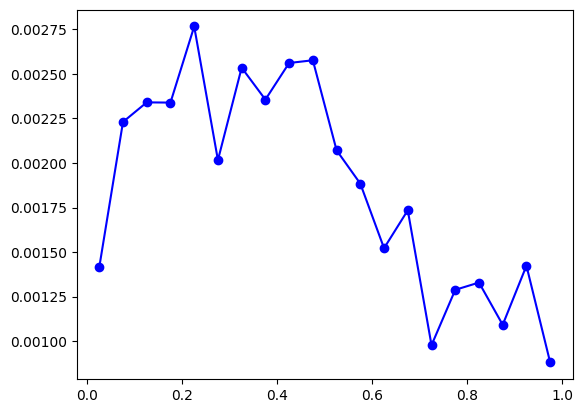

In [19]:
shapley_fda_fnn = ShapleyFda(
    predict_fn=predict_no_verbose(model_fnn.predict),
    #predict_fn=model_fnn.predict,
    X=X_test,
    abscissa_points=fda_simulator.abscissa_points,
    target=target_test,
    domain_range=fda_simulator.domain_range,
    verbose=False,
)

values_shapley_fnn = shapley_fda_fnn.compute_shapley_value(
    num_intervals=num_intervals,
    num_permutations=num_permutations,
)
shapley_fda_fnn.plot()